# Decision Exercise: Mods 15 & 16

## Accounting for Imbalanced Classes in Classification

**Background**

A common challenge in many data science problems is having an imbalanced distribution of the target variable. For example, consider the burden many financial institutions face of detecting and blocking fraudulent credit card transactions. The overwhelming majority of credit card transactiona are not fraudulent. Due to this imbalance, machine learning algorithms will mostly ignore the "positive" (fraudulent) cases simple because there are not enough samples to learn from. To fix this problem, the training data needs to be balanced before model fitting.

One approach for accounting for imbalanced classes is [Synthetic Minority Over-sampling Technique (SMOTE)](https://rikunert.com/SMOTE_explained). The algorithm uses an adaptation of the K-Nearest Neighbor algorithm to create new synthetic instances of the minority class that are similar to the observed minority class instances.

**Prompt**

What are some potential benefits and limitations of using SMOTE to balance data? Can SMOTE be used for both regression and classification use cases? Should testing data be balanced in the same way as training data?

**Data**

The credit card data attached comes from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). The goal of the project is to detect and prevent fraudulent transactions before they occur. The `Class` column contains the labels where `1=fraud` and `0=otherwise`. You may find the [`imbalanced-learn`](https://imbalanced-learn.readthedocs.io/en/stable/) package helpful, as it provides you an easy implementation of SMOTE. 


_Data Source_ : https://www.kaggle.com/mlg-ulb/creditcardfraud

# Import packages 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE, ADASYN

from collections import Counter
from numpy import where

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, r2_score

from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Data set overview

In [6]:
DATAFILE = './datasets/creditcard.csv'
df = pd.read_csv(DATAFILE)

View the head of the DataFrame

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.isnull().any().sum()

0

In [9]:
print(X.shape)
print(y.shape)

NameError: name 'X' is not defined

# Summary of Target Variable

Provide summary of the target variables with % fraudulent and % not fraudulent

In [ ]:
non_fraud = np.round(df['Class'].value_counts(normalize=True)[0]*100,4)
fraud = np.round(df['Class'].value_counts(normalize=True)[1]*100,5)
print("% of Non-Fraudulent:\t", non_fraud)
print("% of Fraudulent:\t", fraud)

In [ ]:
y_class = df['Class'].value_counts()
print(y_class)
y_class.plot(kind="bar")

# Help Functions

In [15]:
def read_data(data_file):
    return pd.read_csv(data_file)
    
def credit_card_data_x_y():
    df = read_data(DATAFILE)
    X = df.drop('Class', axis=1)
    y = df['Class']
    return X,y

def predict_data(data_x_y, classification_model):
    X, y = data_x_y()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    classification_model.fit(X_train, y_train)
    return classification_model.predict(X_test)

def decision_tree_model():
    return tree.DecisionTreeClassifier()

def logistic_regression_binary_clf():
    return LogisticRegression(penalty="l2", C=1.0, solver="liblinear")

def knn_clf():
    return KNeighborsClassifier(n_neighbors = 5)

def balanced_random_forest_clf():
    return BalancedRandomForestClassifier(n_estimators=100, random_state=0)

def model_metrics(data_actual, data_pred):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 6))
    fig.subplots_adjust(wspace=1)
    df_clf_report = pd.DataFrame(classification_report(data_actual, data_pred, output_dict=True)).T
    print(df_clf_report)
    c_m = confusion_matrix(data_actual, data_pred)
    sns.heatmap(c_m, annot=True, fmt=".0f", ax=ax1, square=True, cbar_kws={'orientation': 'horizontal'}) #, vmin=0, vmax=max(map(lambda x: x[2], c_m))
    sns.heatmap(df_clf_report.iloc[: , :-1], annot=True, ax=ax2, square=True, cbar_kws={'orientation': 'horizontal'}) # , vmin=0, vmax=1
    plt.yticks(rotation=0)
    
def classification_app(data_x_y, classification_model):
    X, y = data_x_y()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    model = classification_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    model_metrics(y_test, y_pred)
    
def classification_app_inbld(data_x_y, classification_model, imblearn_method, is_test_oversampled):
    
    X, y = data_x_y()
    
    if is_test_oversampled == False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        X_train, y_train = imblearn_method().fit_sample(X_train, y_train)
    else:
        X_imb, y_imb = imblearn_method().fit_sample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_imb, y_imb, test_size=0.2, random_state=0)
 
    model = classification_model()
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test)
    
    model_metrics(y_test, y_pred)
    

# Classifier Models without Imbalanced Learn Methods

# Decision Tree Classifier 

              precision    recall  f1-score       support
0              0.999613  0.999578  0.999595  56861.000000
1              0.766990  0.782178  0.774510    101.000000
accuracy       0.999192  0.999192  0.999192      0.999192
macro avg      0.883302  0.890878  0.887053  56962.000000
weighted avg   0.999201  0.999192  0.999196  56962.000000


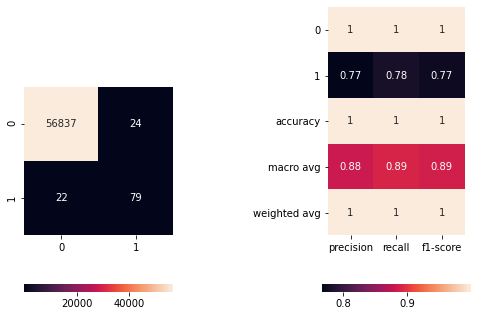

In [460]:
classification_app(credit_card_data_x_y, decision_tree_model)

# Logistic Regression Binary Classifier

              precision    recall  f1-score       support
0              0.999227  0.999648  0.999437  56861.000000
1              0.740260  0.564356  0.640449    101.000000
accuracy       0.998876  0.998876  0.998876      0.998876
macro avg      0.869743  0.782002  0.819943  56962.000000
weighted avg   0.998767  0.998876  0.998801  56962.000000


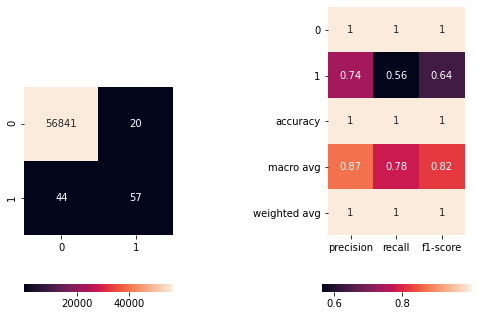

In [461]:
classification_app(credit_card_data_x_y, logistic_regression_binary_clf)

# K-Nearest-Neighboors Classifier

              precision    recall  f1-score       support
0              0.998367  0.999965  0.999165  56861.000000
1              0.800000  0.079208  0.144144    101.000000
accuracy       0.998332  0.998332  0.998332      0.998332
macro avg      0.899184  0.539586  0.571655  56962.000000
weighted avg   0.998015  0.998332  0.997649  56962.000000


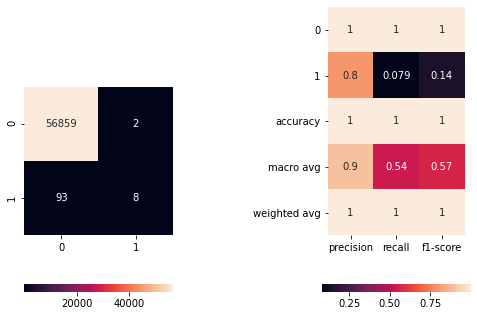

In [14]:
classification_app(credit_card_data_x_y, knn_clf)

# Imbalanced Learn Methods 

# I. SMOTE

“Synthetic Minority Oversampling Technique”


https://www.pluralsight.com/guides/explore-python-libraries:-imbalanced-learn

In [462]:
X, y = credit_card_data_x_y()
X_smote, y_smote = SMOTE().fit_sample(X, y)

1    284315
0    284315
Name: Class, dtype: int64


<AxesSubplot:>

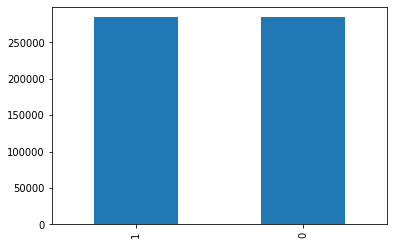

In [464]:
X_smote = pd.DataFrame(X_smote)
y_smote = pd.DataFrame(y_smote)
y_class = y_smote.iloc[:, 0].value_counts()
print(y_class)
y_class.plot(kind="bar")

# Test data is oversampled + Logistic Regression Binary Classification

              precision    recall  f1-score        support
0              0.943540  0.984892  0.963772   56724.000000
1              0.984280  0.941353  0.962338   57002.000000
accuracy       0.963069  0.963069  0.963069       0.963069
macro avg      0.963910  0.963122  0.963055  113726.000000
weighted avg   0.963960  0.963069  0.963053  113726.000000


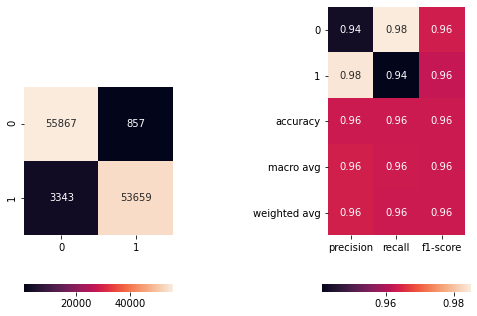

In [471]:
classification_app_inbld(credit_card_data_x_y, logistic_regression_binary_clf, SMOTE, True)

# Test data is not oversampled + Logistic Regression Binary Classification

              precision    recall  f1-score       support
0              0.999821  0.982237  0.990951  56861.000000
1              0.082652  0.900990  0.151414    101.000000
accuracy       0.982093  0.982093  0.982093      0.982093
macro avg      0.541237  0.941614  0.571183  56962.000000
weighted avg   0.998195  0.982093  0.989463  56962.000000


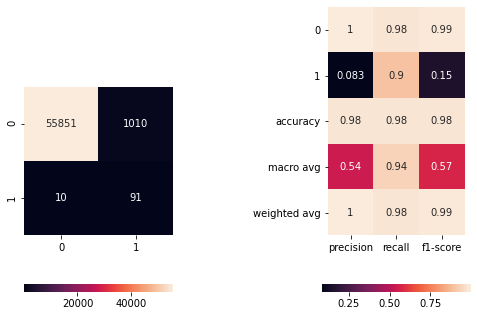

In [472]:
classification_app_inbld(credit_card_data_x_y, logistic_regression_binary_clf, SMOTE, False)

# Test data is oversampled + Decision Tree Classification

              precision    recall  f1-score      support
0              0.998818  0.997973  0.998395   56724.0000
1              0.997984  0.998825  0.998404   57002.0000
accuracy       0.998400  0.998400  0.998400       0.9984
macro avg      0.998401  0.998399  0.998400  113726.0000
weighted avg   0.998400  0.998400  0.998400  113726.0000


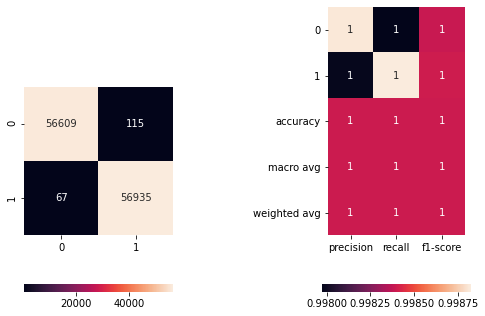

In [469]:
classification_app_inbld(credit_card_data_x_y, decision_tree_model, SMOTE, True)

# Test data is not oversampled + Decision Tree Classification

              precision    recall  f1-score       support
0              0.999665  0.997995  0.998830  56861.000000
1              0.418367  0.811881  0.552189    101.000000
accuracy       0.997665  0.997665  0.997665      0.997665
macro avg      0.709016  0.904938  0.775509  56962.000000
weighted avg   0.998635  0.997665  0.998038  56962.000000


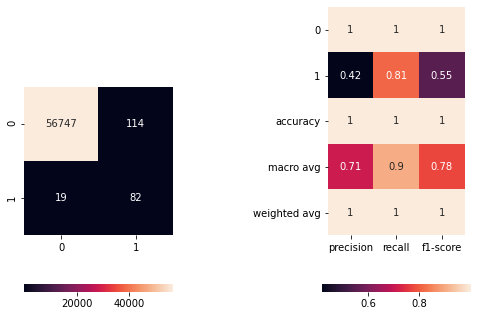

In [470]:
classification_app_inbld(credit_card_data_x_y, decision_tree_model, SMOTE, False)

# Test data is not oversampled + K-Nearest-Neighboor Classifier

              precision    recall  f1-score       support
0              0.999125  0.944021  0.970792  56861.000000
1              0.016682  0.534653  0.032355    101.000000
accuracy       0.943296  0.943296  0.943296      0.943296
macro avg      0.507904  0.739337  0.501573  56962.000000
weighted avg   0.997383  0.943296  0.969128  56962.000000


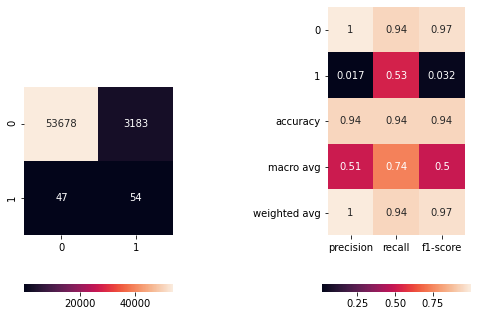

In [17]:
classification_app_inbld(credit_card_data_x_y, knn_clf, SMOTE, False)

# II. ADASYN

"Adaptive Synthetic Sampling Approach"

https://www.pluralsight.com/guides/explore-python-libraries:-imbalanced-learn

In [270]:
X_adasyn, y_adasyn = ADASYN().fit_sample(X, y)

0    284315
1    284298
Name: Class, dtype: int64


<AxesSubplot:>

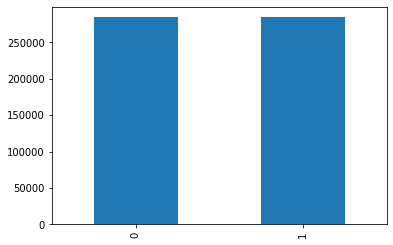

In [271]:
y_class = y_adasyn.value_counts()
print(y_class)
y_class.plot(kind="bar")

# Test data is oversampled + Logistic Regression Binary Classification

              precision    recall  f1-score        support
0              0.954690  0.980640  0.967491   56766.000000
1              0.980167  0.953614  0.966708   56957.000000
accuracy       0.967104  0.967104  0.967104       0.967104
macro avg      0.967429  0.967127  0.967100  113723.000000
weighted avg   0.967450  0.967104  0.967099  113723.000000


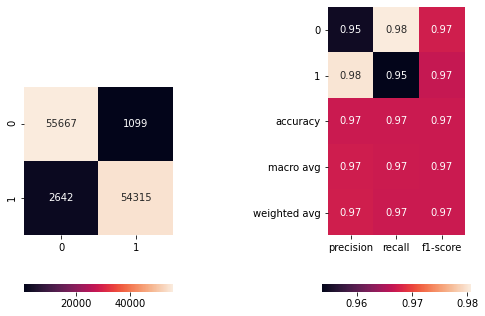

In [473]:
classification_app_inbld(credit_card_data_x_y, logistic_regression_binary_clf, ADASYN, True)

# Test data is not oversampled + Logistic Regression Binary Classification

              precision    recall  f1-score       support
0              0.999821  0.982501  0.991085  56861.000000
1              0.083794  0.900990  0.153328    101.000000
accuracy       0.982357  0.982357  0.982357      0.982357
macro avg      0.541807  0.941746  0.572207  56962.000000
weighted avg   0.998197  0.982357  0.989600  56962.000000


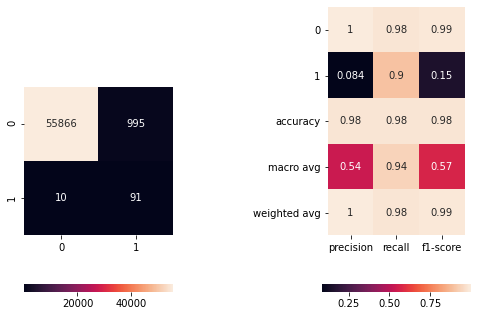

In [474]:
classification_app_inbld(credit_card_data_x_y, logistic_regression_binary_clf, ADASYN, False)

# Test data is oversampled + Decision Tree Classification

              precision    recall  f1-score        support
0              0.999013  0.998080  0.998546   56766.000000
1              0.998088  0.999017  0.998552   56957.000000
accuracy       0.998549  0.998549  0.998549       0.998549
macro avg      0.998550  0.998548  0.998549  113723.000000
weighted avg   0.998550  0.998549  0.998549  113723.000000


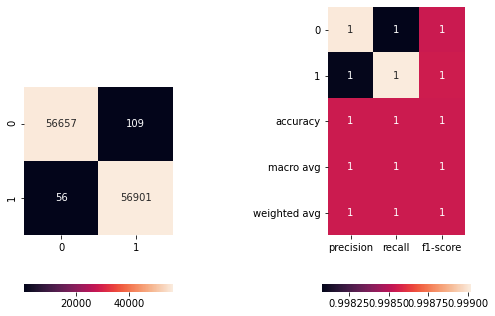

In [475]:
classification_app_inbld(credit_card_data_x_y, decision_tree_model, ADASYN, True)

# Test data is not oversampled + Decision Tree Classification

              precision    recall  f1-score       support
0              0.999595  0.998488  0.999041  56861.000000
1              0.475610  0.772277  0.588679    101.000000
accuracy       0.998086  0.998086  0.998086      0.998086
macro avg      0.737602  0.885382  0.793860  56962.000000
weighted avg   0.998666  0.998086  0.998313  56962.000000


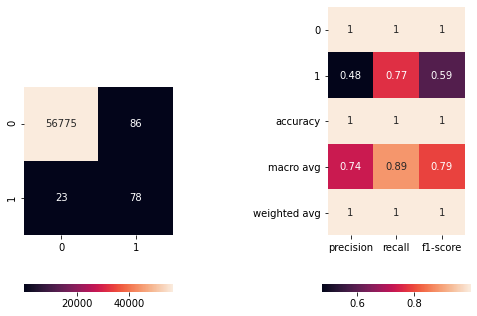

In [476]:
classification_app_inbld(credit_card_data_x_y, decision_tree_model, ADASYN, False)

# Test data is not oversampled + K-Nearest-Neighboor Classifier

              precision    recall  f1-score       support
0              0.999122  0.940592  0.968974  56861.000000
1              0.015734  0.534653  0.030569    101.000000
accuracy       0.939872  0.939872  0.939872      0.939872
macro avg      0.507428  0.737623  0.499771  56962.000000
weighted avg   0.997378  0.939872  0.967310  56962.000000


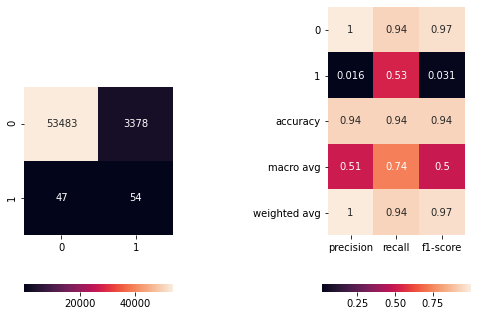

In [16]:
classification_app_inbld(credit_card_data_x_y, knn_clf, ADASYN, False)

# III. Balanced Random Forest Classifier

"BalancedRandomForestClassifier differs from SMOTE and ADASYN in that it is not a resampling method, but rather a classifier in which the training employs resampling internally."

https://www.pluralsight.com/guides/explore-python-libraries:-imbalanced-learn

              precision    recall  f1-score       support
0              0.999856  0.977454  0.988528  56861.000000
1              0.067636  0.920792  0.126016    101.000000
accuracy       0.977353  0.977353  0.977353      0.977353
macro avg      0.533746  0.949123  0.557272  56962.000000
weighted avg   0.998203  0.977353  0.986999  56962.000000


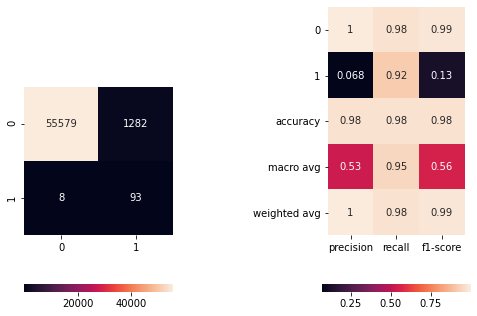

In [480]:
classification_app(credit_card_data_x_y, balanced_random_forest_clf)